In [116]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler , OrdinalEncoder
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestClassifier 
from imblearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [117]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [119]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [120]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [121]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [122]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [123]:
df.isnull().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

# 1. Distribution of target variable

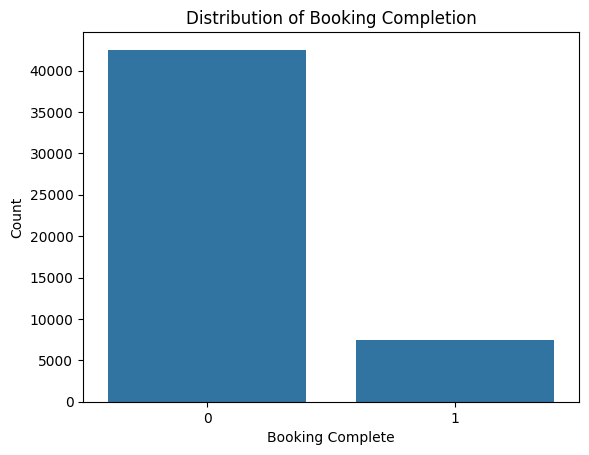

In [124]:
sns.countplot(x='booking_complete', data=df)
plt.title('Distribution of Booking Completion')
plt.xlabel('Booking Complete')
plt.ylabel('Count')
plt.show()

In [125]:
numerical_cols = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour',
                  'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration']
categorical_cols = ['sales_channel', 'trip_type', 'route', 'flight_day', 'booking_origin']

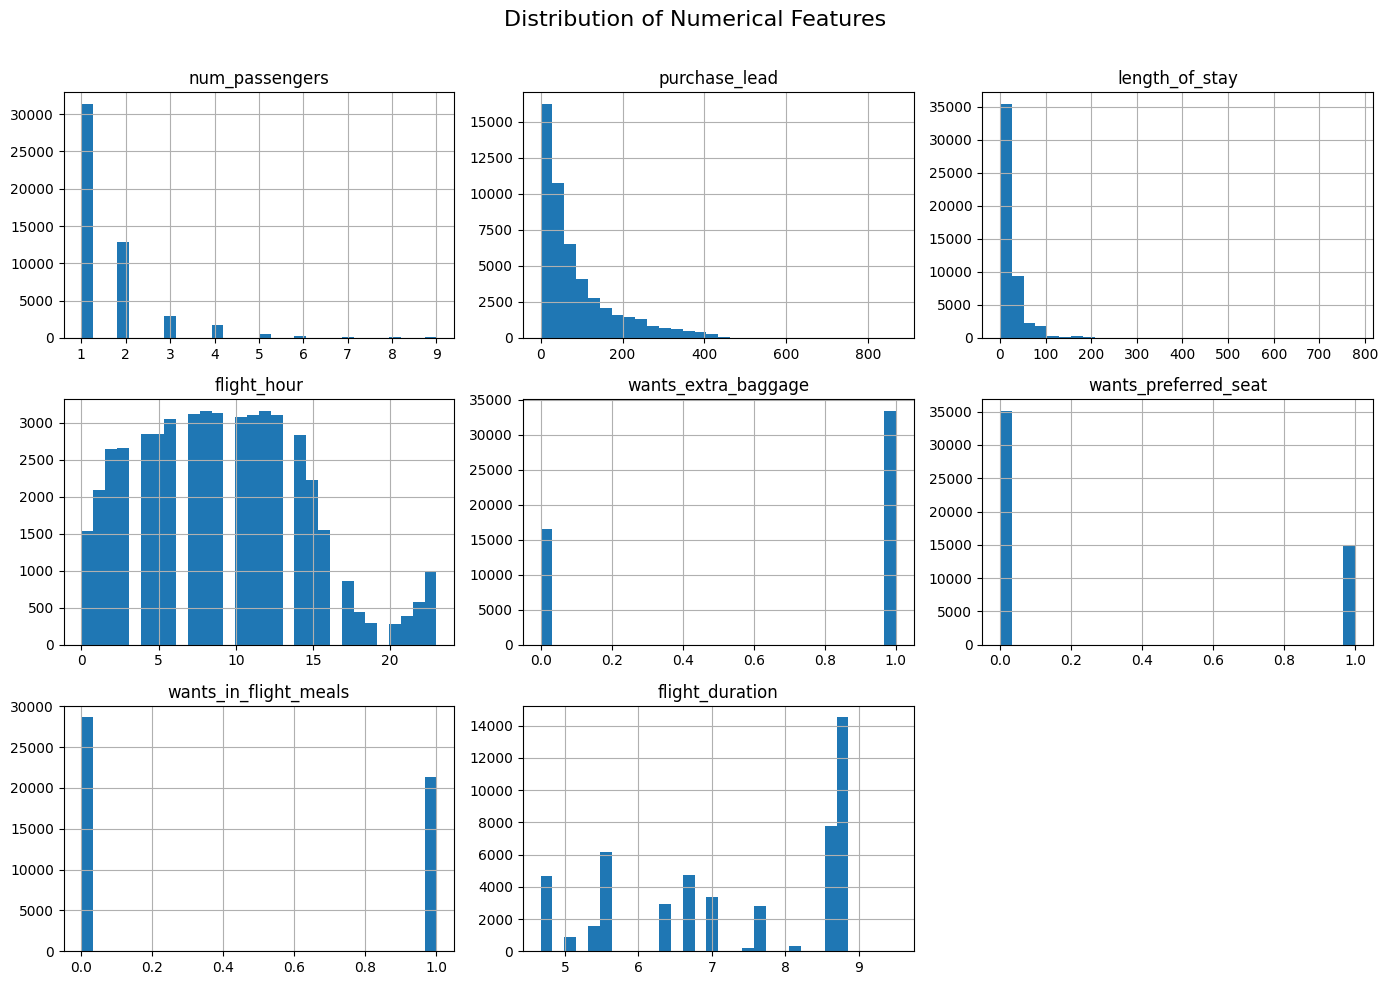

In [126]:
# Distribution of numerical features
df[numerical_cols].hist(figsize=(14, 10), bins=30)
plt.suptitle('Distribution of Numerical Features', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


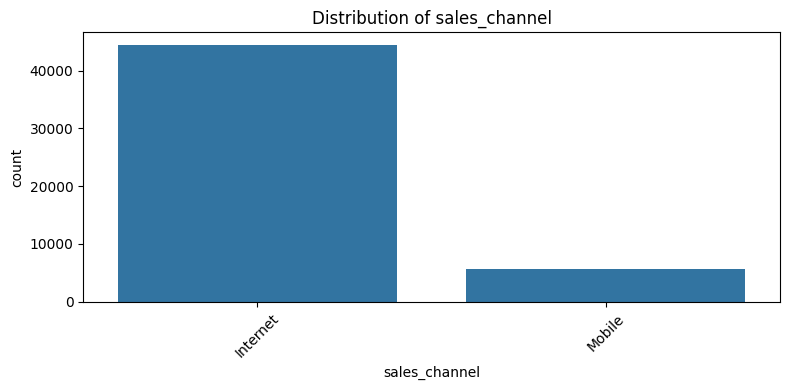

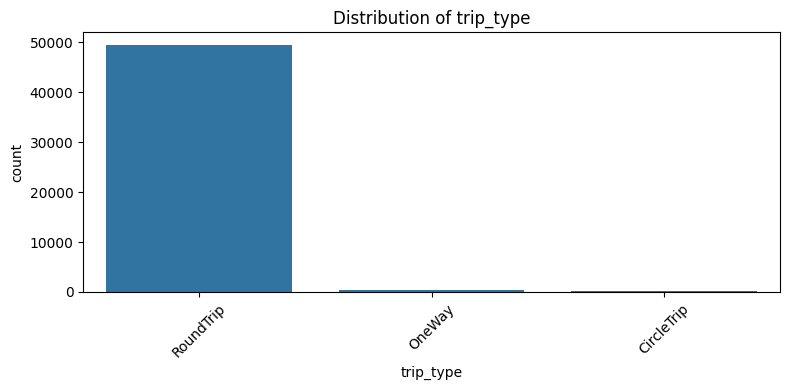

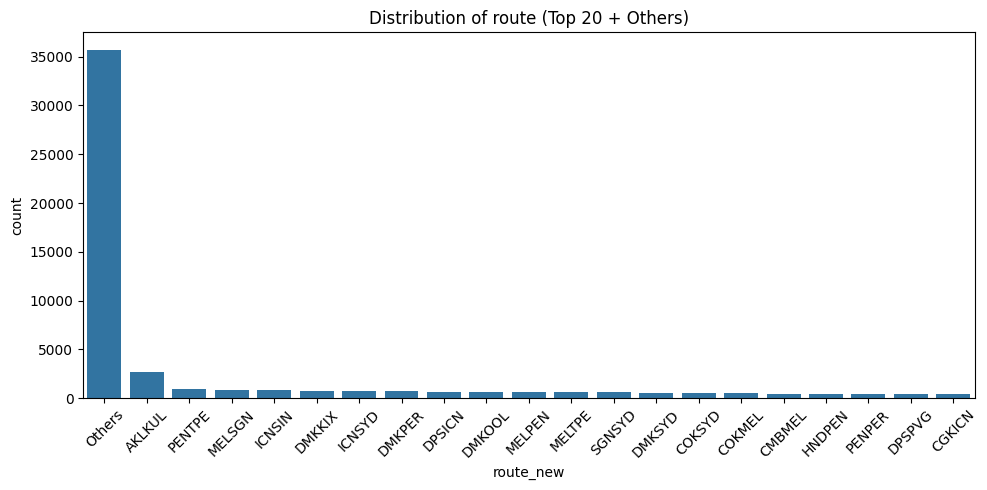

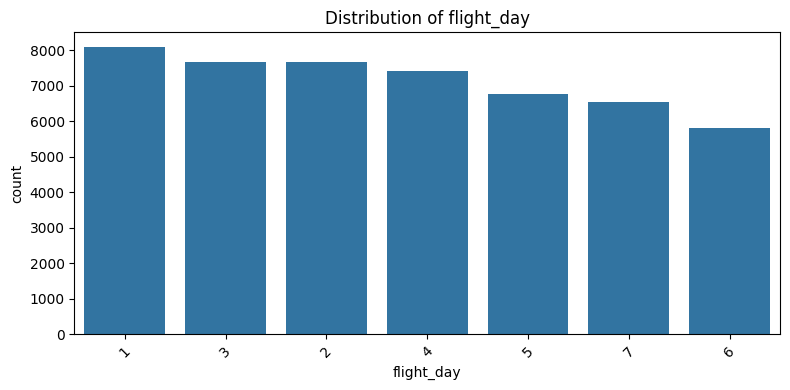

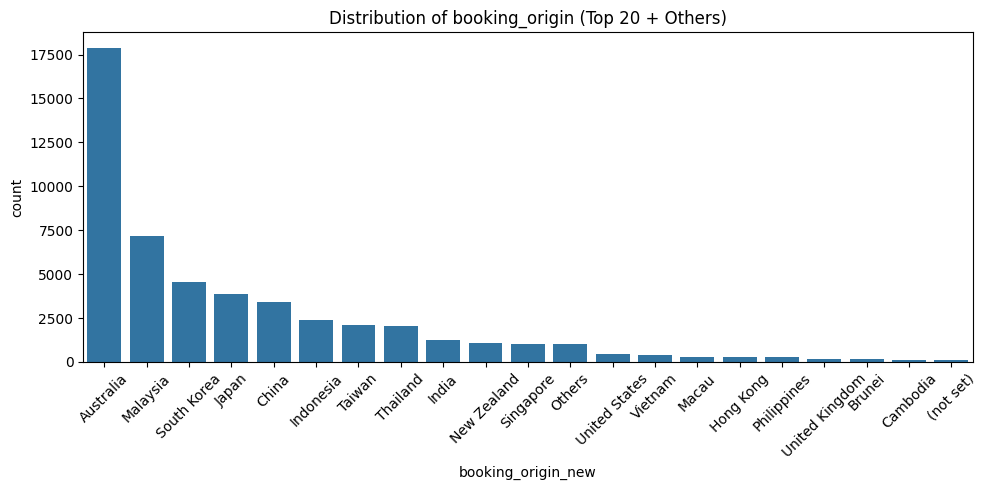

In [127]:
for col in categorical_cols:
    unique_vals = df[col].nunique()
    if unique_vals > 30:
        top_values = df[col].value_counts().index[:20]  # get top 20
        df[col + '_new'] = df[col].where(df[col].isin(top_values), 'Others')
        
        plt.figure(figsize=(10, 5))
        sns.countplot(x=col + '_new', data=df, order=df[col + '_new'].value_counts().index)
        plt.title(f"Distribution of {col} (Top 20 + Others)")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    else:
        plt.figure(figsize=(8, 4))
        sns.countplot(x=col, data=df, order=df[col].value_counts().index)
        plt.title(f"Distribution of {col}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()



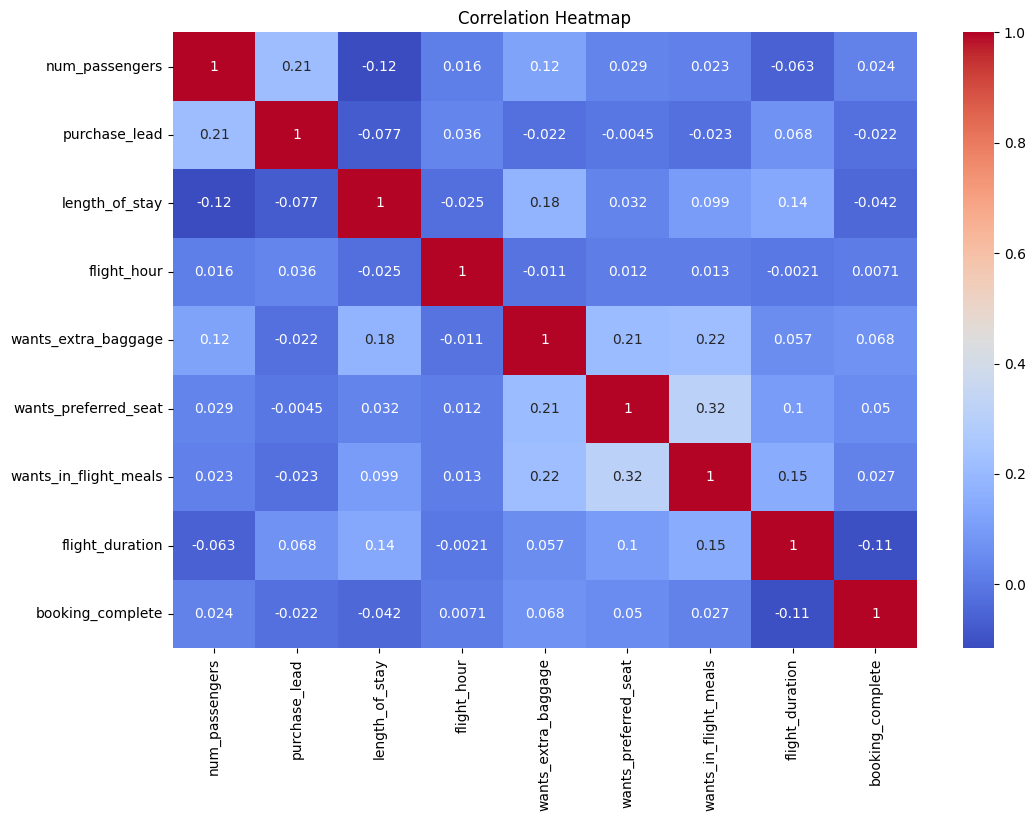

In [128]:
plt.figure(figsize=(12, 8))
sns.heatmap(df[numerical_cols + ['booking_complete']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [129]:
df.drop(columns=["route_new","booking_origin_new"], inplace=True)
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0


# Outliers detection & Removal 

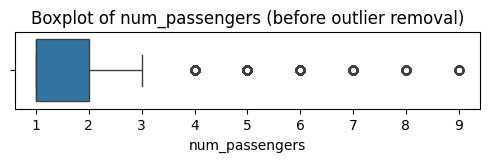

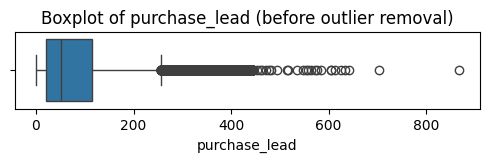

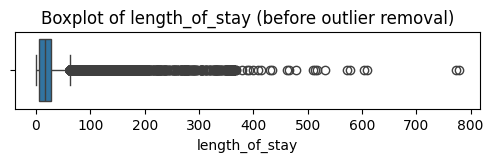

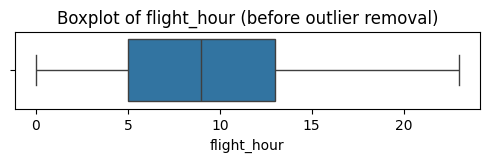

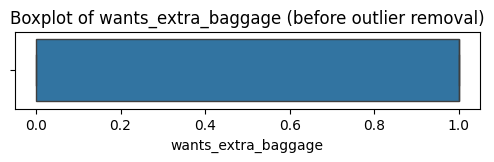

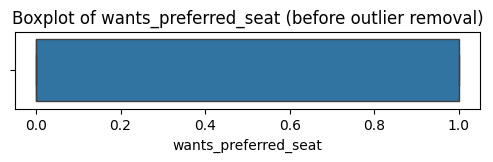

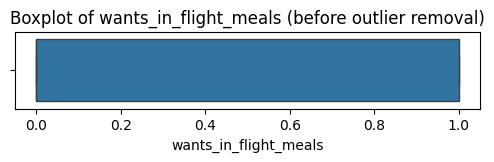

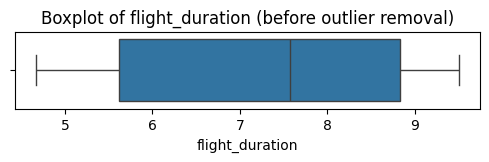

In [130]:
for col in numerical_cols:
    plt.figure(figsize=(6, 1))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col} (before outlier removal)')
    plt.show()

In [131]:
# Remove outliers from all numerical columns using the IQR method
df_no_outliers = df.copy()
for col in numerical_cols:
    q1 = df_no_outliers[col].quantile(0.25)
    q3 = df_no_outliers[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower) & (df_no_outliers[col] <= upper)]

df_no_outliers.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0
5,1,Internet,RoundTrip,3,48,20,4,AKLDEL,New Zealand,1,0,1,5.52,0


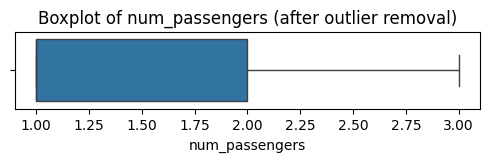

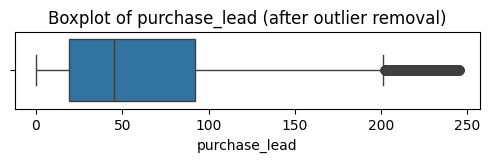

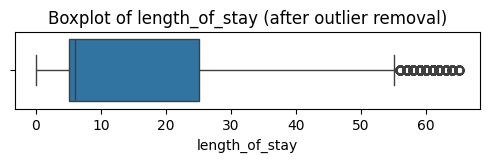

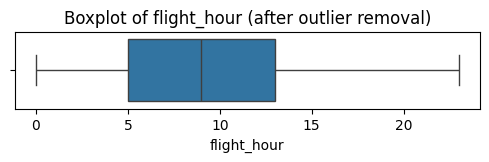

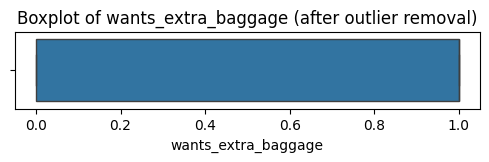

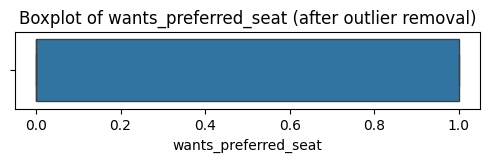

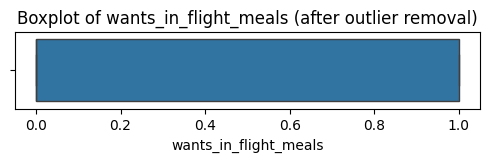

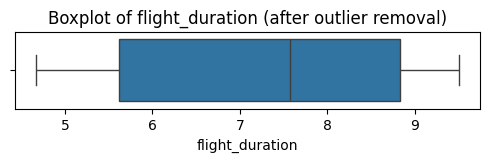

In [132]:
for col in numerical_cols:
    plt.figure(figsize=(6, 1))
    sns.boxplot(x=df_no_outliers[col])
    plt.title(f'Boxplot of {col} (after outlier removal)')
    plt.show()

In [133]:
df_no_outliers.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0
5,1,Internet,RoundTrip,3,48,20,4,AKLDEL,New Zealand,1,0,1,5.52,0


In [134]:
df_no_outliers.columns

Index(['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead',
       'length_of_stay', 'flight_hour', 'flight_day', 'route',
       'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat',
       'wants_in_flight_meals', 'flight_duration', 'booking_complete'],
      dtype='object')

# Feature Extraction

In [135]:
df_no_outliers['booking_urgency'] = df_no_outliers['purchase_lead'] / (df_no_outliers['flight_day'] + 1)

In [136]:
df_no_outliers.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,booking_urgency
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0,16.000000
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0,60.750000
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0,13.714286
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0,17.000000
5,1,Internet,RoundTrip,3,48,20,4,AKLDEL,New Zealand,1,0,1,5.52,0,0.600000


In [137]:
df_no_outliers = df_no_outliers.drop(columns=['purchase_lead'])

In [138]:
df_no_outliers.columns

Index(['num_passengers', 'sales_channel', 'trip_type', 'length_of_stay',
       'flight_hour', 'flight_day', 'route', 'booking_origin',
       'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals',
       'flight_duration', 'booking_complete', 'booking_urgency'],
      dtype='object')

In [139]:
df_no_outliers.sales_channel.value_counts()

sales_channel
Internet    35609
Mobile       4701
Name: count, dtype: int64

In [140]:
X_train, X_test, y_train, y_test = train_test_split(df_no_outliers.drop("booking_complete", axis=1), df_no_outliers["booking_complete"], test_size=0.2, random_state=42)


# Standardization And Encoding Using Column Transfer

In [141]:
high_card_cat =  ["route","booking_origin"]
low_card_cat = ["sales_channel","trip_type"]
transformers = ColumnTransformer(
    transformers=[
        ("scaler",StandardScaler(),["booking_urgency"]),
        ("low_card", OneHotEncoder(drop="first",sparse_output=False), low_card_cat),
        ("high_card", TargetEncoder(), high_card_cat)
    ] , remainder= "passthrough"
)


## Pipelining

In [142]:
pipeline = Pipeline([
    ("transformer",transformers),
    ('rf',RandomForestClassifier(     class_weight='balanced',
    random_state=42,
    n_jobs=-1))
])
pipeline

,steps,"[('transformer', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('scaler', ...), ('low_card', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [143]:
pipeline.fit(X_train, y_train)

,steps,"[('transformer', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('scaler', ...), ('low_card', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [144]:
y_pred = pipeline.predict(X_test)

# Evaluation Of Model

In [145]:
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy Score: 0.8549987596129992

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92      6886
           1       0.51      0.13      0.20      1176

    accuracy                           0.85      8062
   macro avg       0.69      0.55      0.56      8062
weighted avg       0.82      0.85      0.82      8062


Confusion Matrix:
 [[6743  143]
 [1026  150]]


## Feature Importance Graph

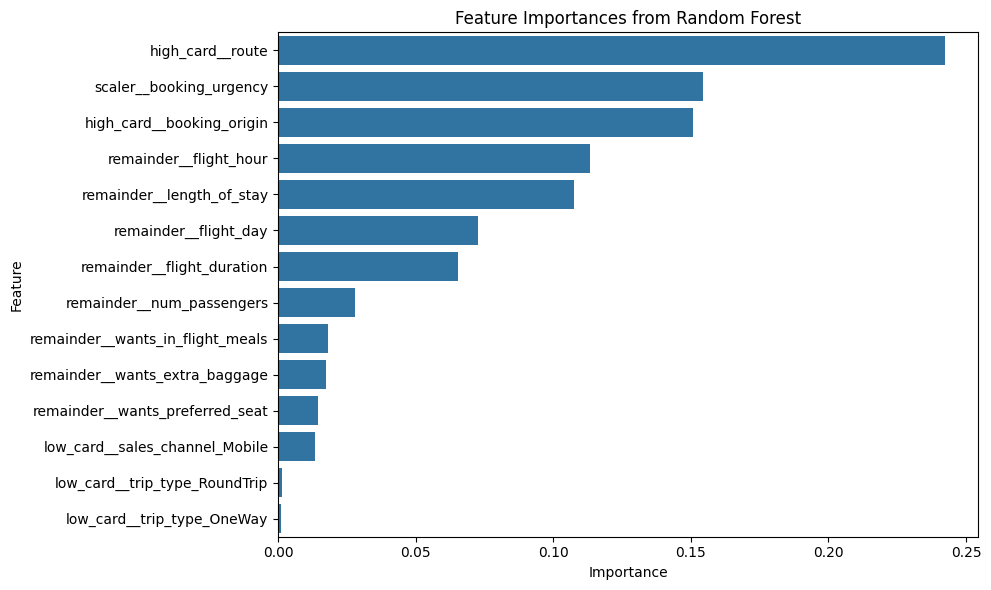

In [146]:
importances = pipeline.named_steps['rf'].feature_importances_
feature_names = (
    pipeline.named_steps['transformer']
    .get_feature_names_out(X_train.columns)
)

indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=np.array(feature_names)[indices])
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Roc Curve Score

In [147]:
from sklearn.metrics import roc_auc_score, roc_curve

y_proba = pipeline.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_proba)
print("ROC AUC Score:", roc_auc)


ROC AUC Score: 0.7852201474548577


## ROC Curve

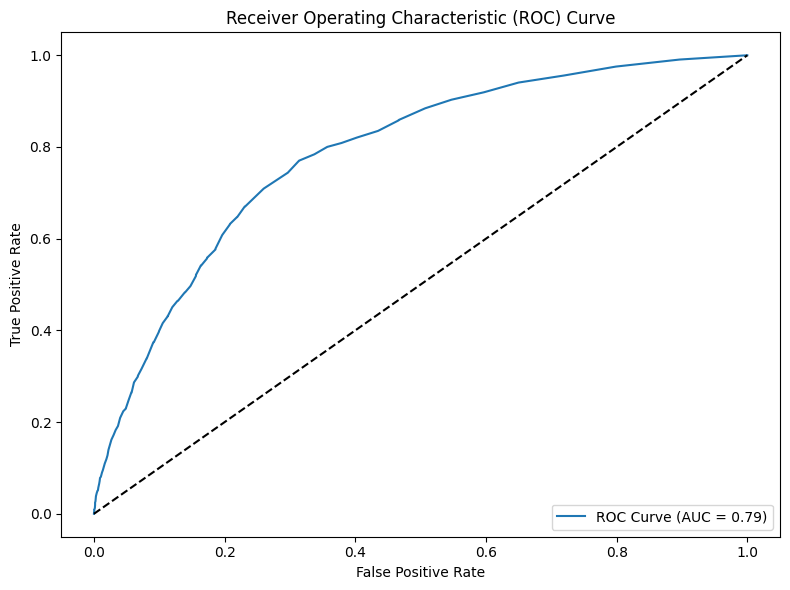

In [148]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()